#### Libraries

In [1]:
import numpy as np
import seaborn as sns
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#### Graph Methods

In [2]:
def get_degree_sequence(graph):
    '''Get a degree sequence of a graph.

    Parameters:
      graph: scipy.sparse.csr.csr_matrix
    '''
    degree_seq = graph.sum(axis=0).A.ravel()
    return degree_seq

In [3]:
def get_degree_distribution(degseq):
    '''Get a degree distribution of a graph.

    Parameters:
      degseq: numpy.ndarray
        A sequence of degrees.
    '''
    degree, frequency = np.unique(degseq, return_counts=True)
    distribution = frequency / frequency.sum()
    return distribution

#### Visibility Graph Methods

In [4]:
def sort_and_conquer(x):
    '''Sort and conquer algorithm proposed by Ghosh et al.'''
    n = x.size
    sortd = np.argsort(x)[::-1]
    graph = sparse.lil_matrix((n, n))
    for i in np.arange(n):
        current = sortd[i]
        connected = graph.rows[current]
        left = -1
        right = n
        for j in connected:
            if j < current:
                left = max(left, j)
            else:
                right = min(right, j)
        wvisibility(x, left, right, current, graph)
    return sparse.csr_matrix(graph)

In [5]:
def wvisibility(x, left, right, i, graph):
    '''Weighted visibility module of sort and conquer algorithm proposed by Ghosh et al.'''
    max_slope = float('-inf')
    min_slope = float('+inf')
    for j in np.arange(i + 1, right):
        slope = (x[j] - x[i]) / (j - i)
        if slope > max_slope:
            max_slope = slope
            graph[i, j] = np.arctan(slope)
            graph[j, i] = np.arctan(slope)
    for j in np.arange(i - 1, left, -1):
        slope = (x[i] - x[j]) / (i - j)
        if slope < min_slope:
            min_slope = slope
            graph[i, j] = np.arctan(slope)
            graph[j, i] = np.arctan(slope)

#### Example of Periodic Time Series

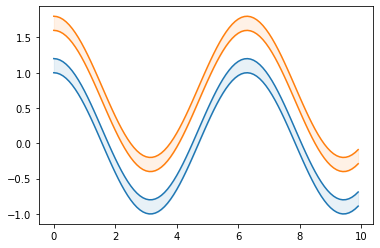

In [6]:
x = np.arange(0, 10, .1)

t0_bot = np.cos(x)
t0_top = t0_bot + .2

t1_bot = np.cos(x) + .6
t1_top = t1_bot + .2

blue = (0.12156862745098039, 
        0.4666666666666667, 
        0.7058823529411765)
ax = sns.lineplot(x, t0_bot, color=blue)
ax = sns.lineplot(x, t0_top, color=blue)
ax.fill_between(x, t0_bot, t0_top, color=blue,  alpha=0.1)

orange = (1.0, 0.4980392156862745, 
          0.054901960784313725)
ax = sns.lineplot(x, t1_bot, color=orange)
ax = sns.lineplot(x, t1_top, color=orange)
ax.fill_between(x, t1_bot, t1_top, color=orange, alpha=0.1)

plt.show()

In [7]:
n = 100
get_sample = lambda a, b: a + (b - a) * np.random.random(*b.shape)

targets = []
ts_features = []
for i in range(n // 2):
    targets.append(0)
    ts_features.append(get_sample(t0_bot, t0_top))
for i in range(n // 2):
    targets.append(1)
    ts_features.append(get_sample(t1_bot, t1_top))

	two time series
	class 0 curve in blue
	class 1 curve in orange


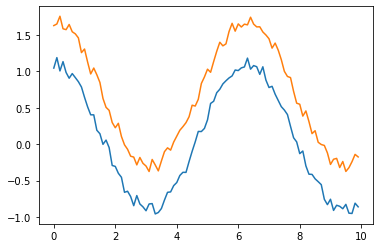

In [23]:
ts0 = ts_features[np.random.randint(0, n // 2)]
ts1 = ts_features[np.random.randint(n // 2, n)]
print(f'\ttwo time series')
print(f'\tclass 0 curve in blue')
print(f'\tclass 1 curve in orange')
sns.lineplot(x, ts0)
sns.lineplot(x, ts1)
plt.show()

#### Example of Visibility Features

In [9]:
vg = list(map(sort_and_conquer, ts_features))
vg_features = map(get_degree_sequence, vg)
vg_features = list(vg_features)

	two time series visibility features
	class 0 curve in blue
	class 1 curve in orange


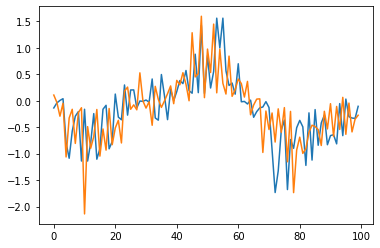

In [22]:
ds0 = vg_features[np.random.randint(0, n // 2)]
ds1 = vg_features[np.random.randint(n // 2, n)]

print(f'\ttwo time series visibility features')
print(f'\tclass 0 curve in blue')
print(f'\tclass 1 curve in orange')
sns.lineplot(range(ds0.size), ds0)
sns.lineplot(range(ds1.size), ds1)
plt.show()

#### Analysing the Results

	time series in blue
	degree sequence in orange


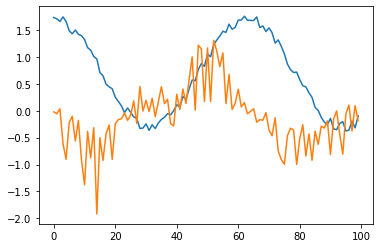

In [11]:
k = np.random.randint(0, n)
print(f'\ttime series in blue')
print(f'\tdegree sequence in orange')
sns.lineplot(range(n), ts_features[k])
sns.lineplot(range(n), vg_features[k])
plt.show()

In [12]:
x_train, x_test, y_train, y_test = train_test_split(ts_features, targets, test_size=0.5, random_state=42)

In [13]:
model = LogisticRegression()
model.fit(x_train, y_train)
print(f'TS Accuracy: {model.score(x_test, y_test)}')

TS Accuracy: 1.0


In [14]:
x_train, x_test, y_train, y_test = train_test_split(vg_features, targets, test_size=0.5, random_state=42)

In [15]:
model = LogisticRegression()
model.fit(x_train, y_train)
print(f'VG Accuracy: {model.score(x_test, y_test)}')

VG Accuracy: 0.36


Note that's not a good representation in this case.

#### Recovering a Curve

In [16]:
def to_curve(vg):
    ts = np.hstack((0, np.diag(vg.A, 1)))
    for i in range(1, ts.size):
        ts[i] = ts[i - 1] + np.tan(ts[i])
    return ts

	sample 75 with class 1
	original curve in blue
	recovered curve in orange


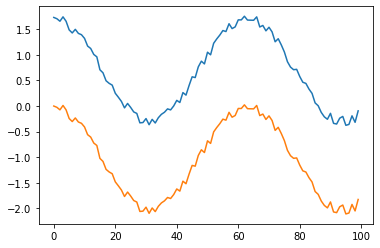

In [17]:
k = np.random.randint(0, n)
sns.lineplot(range(n), ts_features[k])
sns.lineplot(range(n), to_curve(vg[k]))
print(f'\tsample {k} with class {1 if k > 49 else 0}')
print(f'\toriginal curve in blue')
print(f'\trecovered curve in orange')
plt.show()